In [ ]:
# To run this code you need to install the following dependencies:
# pip install google-genai

import base64
import os
from google import genai
from google.genai import types


def generate(input_text):
    client = genai.Client(
        api_key=os.getenv("GOOGLE_API_KEY"),
    )

    model = "gemini-flash-lite-latest"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=input_text),
            ],
        ),
    ]
    generate_content_config = types.GenerateContentConfig(
        thinking_config = types.ThinkingConfig(
            thinking_budget=0,
        ),
        response_mime_type="application/json",
        response_schema=genai.types.Schema(
            type = genai.types.Type.OBJECT,
            required = ["classification", "confidence", "reasoning", "suspicious_terms", "obfuscation_detected"],
            properties = {
                "classification": genai.types.Schema(
                    type = genai.types.Type.STRING,
                ),
                "confidence": genai.types.Schema(
                    type = genai.types.Type.STRING,
                ),
                "reasoning": genai.types.Schema(
                    type = genai.types.Type.STRING,
                ),
                "suspicious_terms": genai.types.Schema(
                    type = genai.types.Type.STRING,
                ),
                "obfuscation_detected": genai.types.Schema(
                    type = genai.types.Type.STRING,
                ),
            },
        ),
        system_instruction=[
            types.Part.from_text(text="""Anda adalah sistem deteksi konten yang mengidentifikasi promosi judi online dalam bahasa Indonesia dan bahasa gaul.

### DEFINISI JUDI ONLINE:
- Situs/aplikasi taruhan uang: slot, poker, togel, casino, sportsbook
- Platform betting olahraga/esports dengan uang nyata
- Semua bentuk gambling online dengan deposit/withdraw uang

### INDIKATOR KUAT (High Confidence):
1. **Nama situs judi** (bahkan dengan obfuscation): SLOT88, D0RA77, 3RAPLAY88, PLUT088, dll
2. **Istilah khas**: gacor/gachor/gacir (dalam konteks menang), maxwin, RTP, scatter, sultan, cuan, halusinasi saldo
3. **Ajakan eksplisit**: daftar, deposit, bonus, cashback, freebet
4. **Link/kontak**: link pendaftaran, nomor WA/Telegram
5. **Testimoni kemenangan**: 'menang 50 juta', 'WD lancar'

### TEKNIK OBFUSCATION UMUM:
- Unicode fancy: 𝗘𝗥𝗔, 𝐃𝐎𝙍𝘼, 𝙋𝙇𝙐𝙏𝙊
- Angka diganti simbol: 7 → 𝟽, 8 → 𝟴
- Spasi antar huruf: D O R A 7 7
- Mix cyrillic: я (bukan R latin)
- Typo disengaja: t0t0 (toto), ag4s (agas)

### BUKAN JUDI:
- Game mobile tanpa uang nyata: Mobile Legends, PUBG, Free Fire, Genshin
- 'Gacor' untuk burung, speaker, motor
- 'Slot' untuk waktu/parkir/jadwal
- Trading/investasi legal: saham, kripto, forex (KECUALI ada indikator judi)
- E-commerce, streaming film, media sosial biasa

### OUTPUT FORMAT:
{
  'classification': 'yes' | 'no',
  'confidence': 'high' | 'medium' | 'low',
  'reasoning': 'penjelasan singkat kenapa diklasifikasi demikian',
  'suspicious_terms': ['term1', 'term2'],
  'obfuscation_detected': true | false
}

---

## FEW-SHOT EXAMPLES

### CONTOH 1 (YES - High Confidence):
**Input:** 𝐃 𝐎 𝙍 𝘼 𝟽 7 emang gachor parah

**Output:**
{
  'classification': 'yes',
  'confidence': 'high',
  'reasoning': 'Nama situs judi dengan obfuscation unicode + istilah 'gachor' (menang terus)',
  'suspicious_terms': ['DORA77', 'gachor'],
  'obfuscation_detected': true
}

### CONTOH 2 (YES - High Confidence):
**Input:** film seru banget sih gabakal bosen nontonnya kayak main 𝗘𝗥𝗔𝗣𝗟𝗔𝗬𝟴𝟴 gabakal bosen dehh

**Output:**
{
  'classification': 'yes',
  'confidence': 'high',
  'reasoning': 'Menyebut nama situs judi ERAPLAY88 dengan obfuscation, analogi 'kayak main' menunjukkan promosi soft selling',
  'suspicious_terms': ['ERAPLAY88'],
  'obfuscation_detected': true
}

### CONTOH 3 (YES - High Confidence):
**Input:** halusinasi saldo drastis thanks 𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥🔥

**Output:**
{
  'classification': 'yes',
  'confidence': 'high',
  'reasoning': 'Testimoni kemenangan ('halusinasi saldo drastis') + nama situs PLUTO88 dengan obfuscation',
  'suspicious_terms': ['halusinasi saldo', 'PLUTO88'],
  'obfuscation_detected': true
}

### CONTOH 4 (YES - Medium Confidence):
**Input:** pengguna menemukan 𝘼 𝙃 𝙈 𝘼 d 𝐓 o 𝐓 𝘖 sebagai sumber daya berharga 🥔

**Output:**
{
  'classification': 'yes',
  'confidence': 'medium',
  'reasoning': 'Nama situs judi AHMADTOTO (togel) dengan obfuscation, meski frasa 'sumber daya berharga' agak samar',
  'suspicious_terms': ['AHMADTOTO', 'TOTO'],
  'obfuscation_detected': true
}

### CONTOH 5 (YES - High Confidence):
**Input:** Daftar di SLOT88 sekarang! Bonus deposit 100% new member. Link di bio!

**Output:**
{
  'classification': 'yes',
  'confidence': 'high',
  'reasoning': 'Promosi eksplisit situs judi dengan ajakan daftar, bonus deposit, dan link',
  'suspicious_terms': ['SLOT88', 'bonus deposit', 'daftar', 'link'],
  'obfuscation_detected': false
}

### CONTOH 6 (YES - High Confidence):
**Input:** Gw menang 50 juta di AG4S, WD cepat 5 menit. WA 08123456789 untuk daftar

**Output:**
{
  'classification': 'yes',
  'confidence': 'high',
  'reasoning': 'Testimoni kemenangan + nama situs + ajakan daftar dengan kontak WA',
  'suspicious_terms': ['menang', 'WD', 'AG4S', 'daftar'],
  'obfuscation_detected': true
}

### CONTOH 7 (YES - High Confidence):
**Input:** Pasang togel hari ini, angka jitu 4D. HK Pools bet minimal 1000

**Output:**
{
  'classification': 'yes',
  'confidence': 'high',
  'reasoning': 'Promosi togel online dengan istilah khas: pasang, angka jitu, HK Pools, bet',
  'suspicious_terms': ['togel', 'angka jitu', 'HK Pools', 'bet'],
  'obfuscation_detected': false
}

### CONTOH 8 (NO - High Confidence):
**Input:** penasaran besok sabtu kau menontonnya biar lega

**Output:**
{
  'classification': 'no',
  'confidence': 'high',
  'reasoning': 'Percakapan biasa tentang menonton (kemungkinan film/acara), tidak ada indikator judi',
  'suspicious_terms': [],
  'obfuscation_detected': false
}

### CONTOH 9 (NO - High Confidence):
**Input:** 561m3s mas anies kalah org gasuka gaya kampanye manfaatin identitas mayoritas

**Output:**
{
  'classification': 'no',
  'confidence': 'high',
  'reasoning': 'Diskusi politik tentang pemilu, tidak ada hubungan dengan judi online',
  'suspicious_terms': [],
  'obfuscation_detected': false
}

### CONTOH 10 (NO - High Confidence):
**Input:** kek film spongebob pas sandy selamatkan spongebob

**Output:**
{
  'classification': 'no',
  'confidence': 'high',
  'reasoning': 'Membahas film kartun, tidak ada indikator judi',
  'suspicious_terms': [],
  'obfuscation_detected': false
}

### CONTOH 11 (NO - High Confidence):
**Input:** Top up diamond Mobile Legends murah! 100 diamond cuma 15rb. Proses cepat!

**Output:**
{
  'classification': 'no',
  'confidence': 'high',
  'reasoning': 'Layanan top up game mobile legal, bukan taruhan uang nyata',
  'suspicious_terms': [],
  'obfuscation_detected': false
}

### CONTOH 12 (NO - Medium Confidence):
**Input:** Burung lovebird gacor juara lomba kemarin, suaranya kristal banget

**Output:**
{
  'classification': 'no',
  'confidence': 'medium',
  'reasoning': ''Gacor' dalam konteks burung kicau, bukan judi. Tidak ada nama situs atau istilah judi lainnya',
  'suspicious_terms': ['gacor'],
  'obfuscation_detected': false
}

### CONTOH 13 (NO - Medium Confidence):
**Input:** Slot waktu meeting hari ini sudah penuh, reschedule besok aja

**Output:**
{
  'classification': 'no',
  'confidence': 'medium',
  'reasoning': ''Slot' merujuk jadwal waktu, bukan slot gambling. Konteks jelas tentang meeting',
  'suspicious_terms': ['slot'],
  'obfuscation_detected': false
}

### CONTOH 14 (YES - Medium Confidence):
**Input:** Coba aja sendiri, gak nyesel deh 🔥 Link di bio yang tau pasti tau

**Output:**
{
  'classification': 'yes',
  'confidence': 'medium',
  'reasoning': 'Soft selling dengan frasa 'yang tau pasti tau' + link bio + emoji api (umum di promosi judi), meski tidak eksplisit',
  'suspicious_terms': ['link bio', 'yang tau pasti tau'],
  'obfuscation_detected': false
}

### CONTOH 15 (NO - High Confidence):
**Input:** Trading Bitcoin hari ini profit 20%, strategi scalping emang joss

**Output:**
{
  'classification': 'no',
  'confidence': 'high',
  'reasoning': 'Membahas trading cryptocurrency yang merupakan investasi legal, bukan judi',
  'suspicious_terms': [],
  'obfuscation_detected': false
}

PENTING!!! LANGSUNG OUTPUT JSON TANPA ADA "```json".
JANGAN ADA \n atau simbol lain diluar format JSON. Jadi harus berformat json agar bisa di parse.

"""),
        ],
    )

    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        print(chunk.text, end="")

if __name__ == "__main__":
    generate("MAIN GACOR di YOU555")

{
  "classification": "yes",
  "confidence": "high",
  "reasoning": "Mengandung nama situs judi (YOU555) dengan substitusi angka (5) dan istilah kemenangan ('gacor') yang sangat khas dalam konteks slot online.",
  "suspicious_terms": [
    "GACOR",
    "YOU555"
  ],
  "obfuscation_detected": true
}

In [3]:
import io
import sys
import json
from tqdm.auto import tqdm

def predict_classification(comment):
    """
    Predicts the classification of a comment using the generate function.

    Args:
        comment: The input comment string.

    Returns:
        'yes', 'no', or the full JSON output if classification is 'unknown' or an error occurs.
    """
    old_stdout = sys.stdout
    redirected_output = io.StringIO()
    sys.stdout = redirected_output

    try:
        generate(comment)
        json_output = redirected_output.getvalue().strip() # Strip whitespace

        if not json_output: # Check for empty output
            return "Error: Empty response from model"

        try:
            classification_data = json.loads(json_output)
            classification = classification_data.get("classification")

            if classification in ["yes", "no"]:
                return classification
            else:
                # Return the full JSON output for unexpected classifications
                return json_output
        except json.JSONDecodeError:
            # Return the raw output if JSON decoding fails
            print(f"Error: JSON parsing failed - Raw output: {json_output}")
            return f"Error: JSON parsing failed - Raw output: {json_output}"

    except Exception as e:
        # Return a more specific error message
        return f"Error processing comment: {comment} - {e}"
    finally:
        sys.stdout = old_stdout

/Users/user/code/penambangan-data/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import pandas as pd

df_test = pd.read_csv("dataset/test.csv")
df_test.head()

,comment,label
0,255 bangun pagi indonesia cerah,0
1,maksudnya bangg medyyfacepurplecrying,0
2,suka banget klo prodcash narsum nya dr tirta ❤,0
3,bkn gamernya kya nya tp fansnya kyanya sih bin...,0
4,manamana ngomongin 𝐌𝐀𝐍𝘿𝘼𝙇𝙄𝙆𝘼𝟕𝟕 keren sih ✌ ✌,1


In [8]:
df_test['predicted_label'] = df_test['comment'].apply(predict_classification)
display(df_test.head())

,comment,label,predicted_label
0,255 bangun pagi indonesia cerah,0,no
1,maksudnya bangg medyyfacepurplecrying,0,no
2,suka banget klo prodcash narsum nya dr tirta ❤,0,no
3,bkn gamernya kya nya tp fansnya kyanya sih bin...,0,no
4,manamana ngomongin 𝐌𝐀𝐍𝘿𝘼𝙇𝙄𝙆𝘼𝟕𝟕 keren sih ✌ ✌,1,yes


In [9]:
# export to csv
df_test.to_csv("dataset/test_predicted_llm.csv", index=False)


In [15]:
df_test = pd.read_csv("dataset/test_predicted_llm.csv")

In [16]:
# change yes to 1 and no to 0
df_test['predicted_label'] = df_test['predicted_label'].map({'yes': 1, 'no': 0})

In [20]:
# drop row that not 1 or 0
df_test = df_test[df_test['predicted_label'].isin([0.0, 1.0])]


In [ ]:
# change predicted_label to int
df_test['predicted_label'] = df_test['predicted_label'].astype(int)

# calculate accuracy
accuracy = (df_test['predicted_label'] == df_test['label']).mean()

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9810


/var/folders/dy/w3zrcjk16_j9zk4q_pr518900000gn/T/ipykernel_82817/378357665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_label'] = df_test['predicted_label'].astype(int)


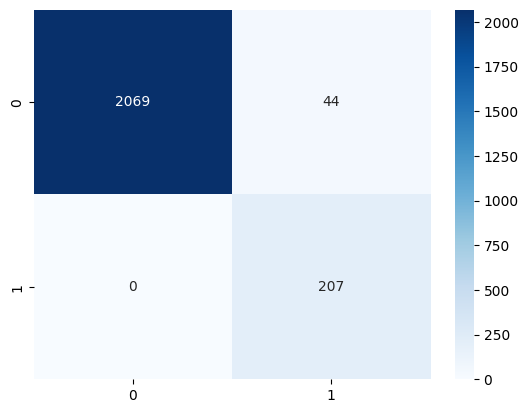

In [25]:
# visualize confusion matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_test['label'], df_test['predicted_label'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()



In [27]:
# show wrong prediction
wrong_prediction = df_test[df_test['predicted_label'] != df_test['label']]
display(wrong_prediction)

# show wrong prediction percentage
wrong_prediction_percentage = (len(wrong_prediction) / len(df_test)) * 100
print(f"Wrong prediction percentage: {wrong_prediction_percentage:.2f}%")

,comment,label,predicted_label
29,simple simple bobolnya si dana hadeh 😮 💨,0,1
155,judol goblog,0,1
250,arti nya lu dapet 10 juta dr kiko bang 🤣,0,1
344,korban judol wd tip tp uang nya gak barokah ke...,0,1
349,w0w murah sekaleee 50jt 😂😂,0,1
376,algoritma akun lo krna buka judol gua ikuti ni...,0,1
419,udh 6jta aja bg,0,1
438,gw beli kiko 1000 an lohhh udh smpe 10000000 😥...,0,1
462,risih banget ya video youtubers isi komennya j...,0,1
604,sultansaurus 😎,0,1


Wrong prediction percentage: 1.90%


## Repredict Error Response

In [55]:
df_predicted = pd.read_csv("dataset/test_predicted_llm.csv")

# Select rows where predicted_label is not "yes" or "no"
error_rows = ~df_predicted['predicted_label'].isin(["yes", "no"])
df_predicted_error = df_predicted[error_rows]

df_predicted_error

,comment,label,predicted_label
149,bang unboxing figure megumin,0,Error: JSON parsing failed - Raw output: {\n ...
323,komplain film anak sma isinya drama cinta cintaan,0,Error: JSON parsing failed - Raw output: {\n ...
346,sering2,0,Error: JSON parsing failed - Raw output: {\n ...
1123,sang kiko satoru 🗿,0,Error: JSON parsing failed - Raw output: {\n ...
1136,upppp,0,Error: JSON parsing failed - Raw output: {\n ...
1216,makan bismillah diendus,0,Error processing comment: makan bismillah dien...
1217,wih 𝑴𝑨𝑵𝑫𝑨𝙇𝙄𝙆𝘼❼❼ booming ya bahas ❼❼,1,Error processing comment: wih 𝑴𝑨𝑵𝑫𝑨𝙇𝙄𝙆𝘼❼❼ boom...
1219,amazing 🎉,0,Error processing comment: amazing 🎉 - 503 UNAV...
1337,makasih banggggh,0,Error: JSON parsing failed - Raw output: {\n ...
1396,mengenang gojo satoru yg udh kiko medy renaldy...,0,Error: JSON parsing failed - Raw output: {\n ...


In [56]:
# predict again error value (not "yes" or not "no") 
df_predicted_error['predicted_label'] = df_predicted_error['predicted_label'].apply(predict_classification)

df_predicted_error

/var/folders/dy/w3zrcjk16_j9zk4q_pr518900000gn/T/ipykernel_82817/581876796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predicted_error['predicted_label'] = df_predicted_error['predicted_label'].apply(predict_classification)


,comment,label,predicted_label
149,bang unboxing figure megumin,0,no
323,komplain film anak sma isinya drama cinta cintaan,0,no
346,sering2,0,no
1123,sang kiko satoru 🗿,0,no
1136,upppp,0,no
1216,makan bismillah diendus,0,no
1217,wih 𝑴𝑨𝑵𝑫𝑨𝙇𝙄𝙆𝘼❼❼ booming ya bahas ❼❼,1,yes
1219,amazing 🎉,0,no
1337,makasih banggggh,0,no
1396,mengenang gojo satoru yg udh kiko medy renaldy...,0,no


In [57]:
df_predicted_error

,comment,label,predicted_label
149,bang unboxing figure megumin,0,no
323,komplain film anak sma isinya drama cinta cintaan,0,no
346,sering2,0,no
1123,sang kiko satoru 🗿,0,no
1136,upppp,0,no
1216,makan bismillah diendus,0,no
1217,wih 𝑴𝑨𝑵𝑫𝑨𝙇𝙄𝙆𝘼❼❼ booming ya bahas ❼❼,1,yes
1219,amazing 🎉,0,no
1337,makasih banggggh,0,no
1396,mengenang gojo satoru yg udh kiko medy renaldy...,0,no


In [58]:
# drop df_predicted error value
df_predicted = df_predicted[df_predicted['predicted_label'].isin(["yes", "no"])]

# merge df_predicted and df_predicted_error
df_predicted = pd.concat([df_predicted, df_predicted_error])

df_predicted



,comment,label,predicted_label
0,255 bangun pagi indonesia cerah,0,no
1,maksudnya bangg medyyfacepurplecrying,0,no
2,suka banget klo prodcash narsum nya dr tirta ❤,0,no
3,bkn gamernya kya nya tp fansnya kyanya sih bin...,0,no
4,manamana ngomongin 𝐌𝐀𝐍𝘿𝘼𝙇𝙄𝙆𝘼𝟕𝟕 keren sih ✌ ✌,1,yes
...,...,...,...
1554,hadirmantap,0,no
1750,mantap nya raja4 mas brotop bget,0,yes
1883,ya allahhh pasangan kerjanya malam semoga seha...,0,no
2075,arsep1311 menyalahkan faktanyamau,0,no


In [59]:
# check is there any error value
error_rows = ~df_predicted['predicted_label'].isin(["yes", "no"])
df_predicted_error2 = df_predicted[error_rows]

df_predicted_error2

,comment,label,predicted_label


In [60]:
# change yes to 1 and no to 0
df_predicted['predicted_label'] = df_predicted['predicted_label'].map({'yes': 1, 'no': 0})

In [61]:
df_predicted

,comment,label,predicted_label
0,255 bangun pagi indonesia cerah,0,0
1,maksudnya bangg medyyfacepurplecrying,0,0
2,suka banget klo prodcash narsum nya dr tirta ❤,0,0
3,bkn gamernya kya nya tp fansnya kyanya sih bin...,0,0
4,manamana ngomongin 𝐌𝐀𝐍𝘿𝘼𝙇𝙄𝙆𝘼𝟕𝟕 keren sih ✌ ✌,1,1
...,...,...,...
1554,hadirmantap,0,0
1750,mantap nya raja4 mas brotop bget,0,1
1883,ya allahhh pasangan kerjanya malam semoga seha...,0,0
2075,arsep1311 menyalahkan faktanyamau,0,0


Accuracy: 0.9807
Precision: 0.8228
Recall: 1.0000
F1 Score: 0.9028


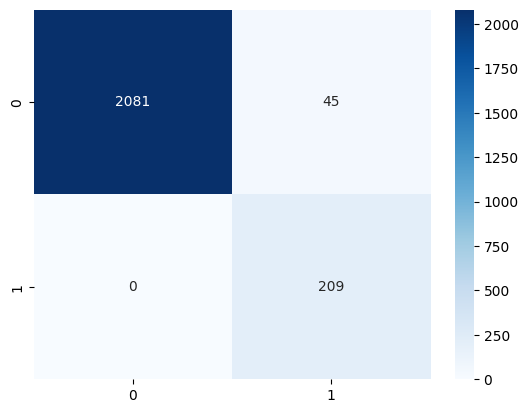

In [64]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# evaluate accuracy, precision, recall, f1 score
accuracy = (df_predicted['predicted_label'] == df_predicted['label']).mean()
precision = precision_score(df_predicted['label'], df_predicted['predicted_label'])
recall = recall_score(df_predicted['label'], df_predicted['predicted_label'])
f1 = f1_score(df_predicted['label'], df_predicted['predicted_label'])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# visualize confusion matrix
cm = confusion_matrix(df_predicted['label'], df_predicted['predicted_label'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [65]:
# export final result
df_predicted.to_csv("dataset/test_predicted_llm_final.csv", index=False)